In [3]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [4]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [5]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

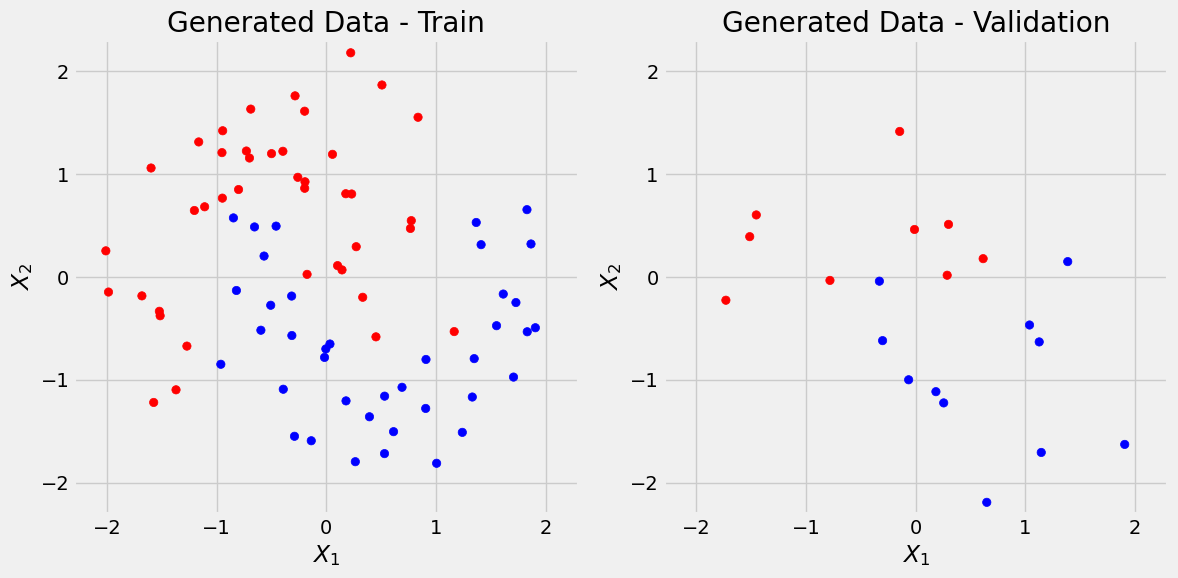

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.style.use('fivethirtyeight')

def figure1(X_train, y_train, X_val, y_val, cm_bright=None):
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)#, edgecolors='k')
    ax[0].set_xlabel(r'$X_1$')
    ax[0].set_ylabel(r'$X_2$')
    ax[0].set_xlim([-2.3, 2.3])
    ax[0].set_ylim([-2.3, 2.3])
    ax[0].set_title('Generated Data - Train')

    ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright)#, edgecolors='k')
    ax[1].set_xlabel(r'$X_1$')
    ax[1].set_ylabel(r'$X_2$')
    ax[1].set_xlim([-2.3, 2.3])
    ax[1].set_ylim([-2.3, 2.3])
    ax[1].set_title('Generated Data - Validation')
    fig.tight_layout()
    
    return fig

fig = figure1(X_train, y_train, X_val, y_val)

In [7]:
import numpy as np
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [8]:
torch.manual_seed(23)

# 从numpy数组转换为张量，并转置了y
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# 创建数据集
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [9]:
# 定义模型
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 线性层，输入维度2，输出维度1
        self.linear = nn.Linear(2, 1)
        # Sigmoid输出层
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.linear(x)
        return self.sigmoid(y)


In [13]:
def mini_batch_train(data_loader,model,optimizer,loss_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        # 置为训练状态
        model.train()
        # Step 1 - 前向计算预测值
        yhat = model(x_batch)
        # Step 2 - 计算损失
        mini_batch_loss = loss_fn(yhat, y_batch)
        # Step 3 - 计算梯度
        mini_batch_loss.backward()
        # Step 4 - 参数更新
        optimizer.step()
        optimizer.zero_grad()

        mini_batch_losses.append(mini_batch_loss.item())
                  
    loss = np.mean(mini_batch_losses)
    return loss

In [14]:
def mini_batch_val(data_loader,model,loss_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        # 置为验证状态
        model.eval()
        # Step 1 - 前向计算预测值
        yhat = model(x_batch)
        # Step 2 - 计算损失
        mini_batch_loss = loss_fn(yhat, y_batch)
        mini_batch_losses.append(mini_batch_loss.item())
                  
    loss = np.mean(mini_batch_losses)
    return loss

In [16]:
n_epochs = 100

# 指定随机数种子，可以再现数据
np.random.seed(23)
torch.manual_seed(23)

# 循环轮数计数
total_epochs = 0

losses = []  # 每轮训练的损失
val_losses = [] #  每轮验证数据的损失
lr = 0.1  # 学习率

# 定义模型
model = ClassificationModel()

# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=lr)

# 定义损失函数
loss_fn = nn.BCELoss(reduction='mean')

for epoch in range(n_epochs):
    total_epochs += 1

    # 进入mini-batch的内循环
    loss = mini_batch_train(train_loader,model,optimizer,loss_fn)
    losses.append(loss)

    # 验证数据集（验证不需要计算梯度）
    with torch.no_grad():
        # 验证集的 mini_batch
        val_loss = mini_batch_val(val_loader,model,loss_fn)
        val_losses.append(val_loss)

print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1841, -1.8763]])), ('linear.bias', tensor([-0.0604]))])


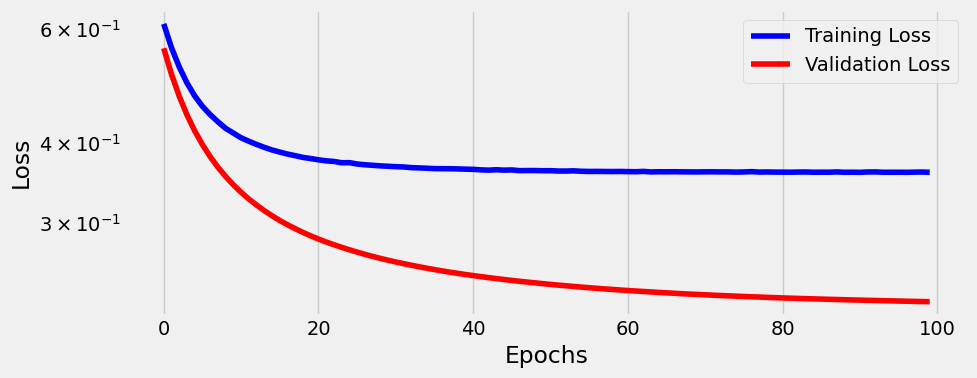

In [17]:
def plot_losses():
    fig = plt.figure(figsize=(10, 4))
    plt.plot(losses, label='Training Loss', c='b')
    plt.plot(val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

fig=plot_losses()